# Table of Content

1. [Introduction](#Introduction)
2. [Imports](#Imports)
3. [Data Preprocessing](#Data-Preprocessing)
4. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
5. [Data Processing](#Data-Processing)<br>
5.1 [Normalization](#Normalization) <br>
5.2 [Reshape](#Reshape) <br>
5.3 [Categorization](#Categorization) <br>
5.4 [Train Test Split](#Train-Test-Split) <br>
6. [Data Augmentation](#Data-Augmentation)
7. [Convolutional Neural Network](#Convolutional-Neural-Network)
8. [Evaluate the Model](#Evaluate-the-Model)
9. [Prediction](#Prediction)

## Introduction

This notebook is an attempt at solving a digit recognition problem. I built a Convolutional Neural Network (CNN) using Keras on top of a Tensorflow backend.

## Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Activation, Conv2D, Dense, Dropout, Flatten, Input, MaxPool2D
import keras.optimizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

/Users/paulfournier/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Data Preprocessing

In [2]:
# Load the data
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [3]:
processed_df = train_df.copy()
processed_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The first column represents the digit that the pixels represent and the columns pixel0:pixel783 are the pixels in a 28 by 28 image.

In [4]:
processed_df.columns

Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)

The data is already in integers.

In [5]:
processed_df.dtypes.head()

label     int64
pixel0    int64
pixel1    int64
pixel2    int64
pixel3    int64
dtype: object

## Exploratory Data Analysis

There seems to be a balanced number of each of the digits from 0 to 9 in the set. So there is no need to stratify the data before the train-test split.

In [5]:
train_df.groupby("label").count()["pixel0"]

label
0    4132
1    4684
2    4177
3    4351
4    4072
5    3795
6    4137
7    4401
8    4063
9    4188
Name: pixel0, dtype: int64

The data represents a pixel value on a scale of 0 to 255.

In [6]:
train_df.max()

label         9
pixel0        0
pixel1        0
pixel2        0
pixel3        0
pixel4        0
pixel5        0
pixel6        0
pixel7        0
pixel8        0
pixel9        0
pixel10       0
pixel11       0
pixel12     116
pixel13     254
pixel14     216
pixel15       9
pixel16       0
pixel17       0
pixel18       0
pixel19       0
pixel20       0
pixel21       0
pixel22       0
pixel23       0
pixel24       0
pixel25       0
pixel26       0
pixel27       0
pixel28       0
           ... 
pixel754      0
pixel755      0
pixel756      0
pixel757      0
pixel758      0
pixel759      0
pixel760      0
pixel761    177
pixel762    231
pixel763    253
pixel764    254
pixel765    254
pixel766    255
pixel767    255
pixel768    255
pixel769    255
pixel770    255
pixel771    255
pixel772    255
pixel773    255
pixel774    254
pixel775    254
pixel776    253
pixel777    253
pixel778    254
pixel779     62
pixel780      0
pixel781      0
pixel782      0
pixel783      0
Length: 785, dtype: int6

### Normalization

Our Convolutional Neural Network will perform better when the pixel values are normalized. When an image has poor quality (like contrast due to glare) we will still be able to train our model confidently.

In [7]:
y_train = train_df["label"]
x_train = train_df.drop(["label"], 1)

In [8]:
x_train_normalized = normalize(x_train)
test_df_normalized = normalize(test_df)

### Reshape

The data is now a Numpy Dataframe with each value representing a pixel intensity. We are going to build a CNN so we need to convert it to an actual image: 28 pixels by 28 pixels.

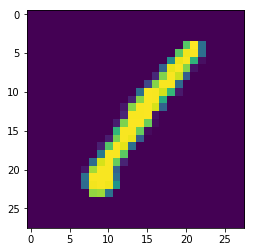

In [9]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
x_train_normalized = x_train_normalized.reshape(-1,28,28,1)
test_df_normalized = test_df_normalized.reshape(-1,28,28,1)

g = plt.imshow(x_train_normalized[0][:,:,0])

### Categorization

The activation function of the last layer of our CNN will be a softmax function (which will tell the level of certainty with witch the model is about the categorization), so we will one hot encode the categories to achieve better results.

In [10]:
y_train = to_categorical(y_train, num_classes = 10)

### Train-Test Split

Let us split the data into a training (90%) and testing set (10%).

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x_train_normalized, y_train, test_size = 0.1)

## Data Augmentation

This step is made to generate a new set of data to train the model on from the given data. <br>
Depending on the handwritting, the orientation of number will differ, we need our model to capture the different orientations so we will create additional images from original ones rotating them. In addition, some numbers can be recognized when flipped horizontally and/or vertically, like zero or eight, but some others could be confused with others, like a six and nine. To avoid deceiving the model, we will just zoom and shift on the original data.

In [12]:
datagen = ImageDataGenerator(
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
)

datagen.fit(x_train)

## Convolutional Neural Network

Our CNN has the following architecture: two Conv2D layer it has size 32. The convolution is performed by a kernel (matrix) of 5 by 5. This choice of parameters is made to maximize the extraction of generic shapes in the layer. Then a MaxPool2D layer is added as well as a Dropout layer with probability 50% (so about half of the values from the previous layer will be dropped, this is done to avoid overfitting in our model). Then we add the same layers before finishing with a Flatten and a Dense Layer. The layers have a bigger number of unit as we go deeper. This is done to ensure that shapes captured in the deeper layers are simply combinations of the generic shapes captured in the shallow layers.

In [13]:
x = Input(shape=(28,28,1))
hidden = Conv2D(32, kernel_size=(5, 5), strides=(1, 1), activation='relu')(x)
hidden = Conv2D(32, kernel_size=(5, 5), strides=(1, 1), activation='relu')(hidden)
hidden = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(hidden)
hidden = Dropout(0.5)(hidden)
hidden = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), activation='relu')(hidden)
hidden = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), activation='relu')(hidden)
hidden = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(hidden)
hidden = Dropout(0.5)(hidden)
hidden = Flatten()(hidden)
hidden = Dense(128, activation='relu')(hidden)
y = Dense(10, activation='softmax')(hidden)

model = Model(inputs=x, outputs=y)

Use the Adam optimizer as it has the best training cost reduction with more epochs. ([ref](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2017/05/Comparison-of-Adam-to-Other-Optimization-Algorithms-Training-a-Multilayer-Perceptron.png)). I will train it with two callbacks: EarlyStopping to avoid overfitting and ReduceLROnPlateau to change the learning rate and improve learning when validation loss does not change.

In [16]:
# optimizer = keras.optimizers.SGD(lr=0.01, momentum=0., decay=0., nesterov=False)
# optimizer = keras.optimizers.Adagrad(lr=0.01, epsilon=1e-6)
# optimizer = keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=1e-6)
# optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-6)
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=2, verbose=1, factor=0.4, min_lr=0.000001)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')


model.compile(loss=keras.losses.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])

In [17]:
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=64),
                              epochs = 1, validation_data = (x_test, y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0],
                              callbacks=[learning_rate_reduction, early_stopping])

Epoch 1/1
37800/37800 [==============================] - 9189s 243ms/step - loss: 0.0720 - acc: 0.9777 - val_loss: 0.0253 - val_acc: 0.9940


In [18]:
model.save('model.h5')

## Evaluate the Model

Let us look at where the model is wrong with the confusion matrix (we will see if patterns of errors are recurrent).

In [19]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 


NameError: name 'Y_pred' is not defined

In [ ]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (y_pred_classes - y_true != 0)

y_pred_classes_errors = y_pred_classes[errors]
y_pred_errors = y_pred[errors]
y_true_errors = y_true[errors]
x_val_errors = x_test[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
y_pred_errors_prob = np.max(y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(y_pred_errors, y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, x_val_errors, y_pred_classes_errors, y_true_errors)

## Submission

In [ ]:
prediction = model.predict(test_df_normalized)
prediction = np.argmax(prediction, axis = 1)
prediction = pd.Series(prediction, name="Label")

In [ ]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"), predicion],axis = 1)
submission.to_csv("hello.csv",index=False)
